# Image Processor
The goal of this notebook is to create a model that can classify images of the following two classes:
- Kaninchen
- Feldhase

To do so, the following steps are performed: 

First, the images are loaded based on their class. Following, the data is randomly split into train (60%), validation (20%), and test (20%) data. The data is split using stratification to ensure that the distribution of the two classes is 50% Feldhase and 50% Kaninchen in each data set. The data is also shuffled with each epoch to prevent the model from learning the order of the images.

Next, data augmentation is applied to artificially increase the size of the train data set. This prevents overfitting and improves the generalization of the model. The test and validation data is scaled only.

With the data being ready, the model is created. We use a sequential model leading to a feed forward neural network. The model consists of several convolutional layers to detect features in the images, max pooling layers to reduce the dimensionality of the data, and dense layers to learn the classification. The output layer classifies the images as either a Kaninchen or a Feldhase.

The model is configured using the adam optimizer which utilizes both an adaptive learning rate and a momentum term. The adaptive learning rate adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case). The momentum term accelerates the learning process in the right direction and dampens oscillations.

The model is furthermore trained using early stopping to prevent overfitting.

Finally, the model is evaluated based on the test data. Our current accuracy high-score is about 83%.

The comments in this notebook are plenty and generated mostly utilizing the help of artificial intelligence. This approach is chosen, as it enables both the developers and the users of this notebook to understand the code better.

# Imports

In [83]:
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.src.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random

# Adjust the GPU memory growth dynamically

In [84]:
gpus = tf.config.experimental.list_physical_devices('GPU') # Get the list of GPUs
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True) # enable tensorflow to allocate memory dynamically -> use only as much GPU memory as needed
gpus

[]

In [85]:
tf.config.list_physical_devices('GPU') # Check if GPU is available

[]

# Load data

In [119]:
# Paths to the class directories
base_dir = 'photos' 
feldhase_dir = os.path.join(base_dir, 'Feldhase')  # .join concatenates the paths and adds a slash if necessary
kaninchen_dir = os.path.join(base_dir, 'Kaninchen')

# Getting image file paths and labels
images = [] # create an empty list to store the image file paths
labels = []

# listdir lists all files in a directory
for filename in os.listdir(feldhase_dir):
    # only consider pictures
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # append full image path to the list
        images.append(os.path.join(feldhase_dir, filename)) 
        # append image label to the list
        labels.append('Feldhase')

for filename in os.listdir(kaninchen_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        images.append(os.path.join(kaninchen_dir, filename))
        labels.append('Kaninchen')
        
print("Found " + str(len(labels)) + " images belonging to " + str(len(set(labels))) + " classes.")


# Create a DataFrame
data = pd.DataFrame({'filename': images, 'class': labels})

Found 400 images belonging to 2 classes.


# Split data into train, validation, and test data

In [87]:
# Split the data into train (60%), validation (20%), and test (20%) data
# stratify ensures that the distribution of the classes is the same in the train, validation, and test data (50% Feldhase, 50% Kaninchen in each data set)
# random_state ensures that the split is reproducible
# train_test_split also shuffles the data
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# Apply data augmentation to artificially increase the size of the train data set

In [88]:
# Create an ImageDataGenerator instance with various data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Scale the images to values between 0 and 1
    rotation_range=10,      # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1, # Randomly shift images vertically by up to 10%
    shear_range=0.2,        # Shear transformation to tilt the image by up to 20%
    zoom_range=0.2,         # Randomly zoom in on images by up to 20%
    horizontal_flip=False,  # Randomly flip images horizontally, does not make sense in or case
    vertical_flip=True,     # No vertical flipping in this example
    fill_mode='nearest'     # Fill in missing pixels with the nearest available pixel
)

test_val_datagen = ImageDataGenerator(  # No data augmentation for the validation and test data
    rescale=1./255                      # Just perform the rescaling
)


# Load data and apply transformations
train_set = train_datagen.flow_from_dataframe(
    train_data,                 # use previously created train data set
    x_col='filename',           # c_col is the column with the file names
    y_col='class',              # y_col is the column with the labels
    target_size=(256, 256),     # resize the images to 256x256 pixels
    batch_size=32,              # take 32 images per processing step
    shuffle=True,               # order of images is shuffled with each epoch
    seed=42,                    # set random seed for shuffling and transformations leading to reproducible results
    class_mode='binary'         # binary classification (Feldhase or Kaninchen)
)

validation_set = test_val_datagen.flow_from_dataframe(
    val_data, 
    x_col='filename', 
    y_col='class', 
    target_size=(256, 256), 
    batch_size=32, 
    shuffle=True, 
    seed=42, 
    class_mode='binary'
)

test_set = test_val_datagen.flow_from_dataframe(
    test_data, 
    x_col='filename', 
    y_col='class', 
    target_size=(256, 256), 
    batch_size=32, 
    shuffle=True, 
    seed=42, 
    class_mode='binary'
)

Found 240 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.


# Create the model

In [89]:
# sequential means that the layers are stacked on top of each other leading to a feed forward neural network
model = tf.keras.models.Sequential([
    # Adding a convolutional layer to detect features in the images
    
    # 16 filters to detect 16 different features like edges, textures, structure etc.
    # 3x3 kernel size to detect features in a 3x3 area
    # 1 stride to move the kernel by 1 pixel
    # relu activation function to introduce non-linearity
    # input shape: height, width, colors/channels (RGB)
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)), # output shape: 254x254x16 (width, height, features)

    # Adding a max pooling layer to reduce the dimensionality of the data
    # achieved by taking the maximum value of a 2x2 area as the representative value for that area
    tf.keras.layers.MaxPool2D(), # output shape: 127x127x16
    
    # Adding more layers to continously learn more complex features
    # Continouse learning of more complex features is achieved by increasing the number of filters
    # A more compact representation of the data is achieved by reducing the kernel size continuously via max pooling
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'), # output shape: 125x125x32
    tf.keras.layers.MaxPool2D(), # output shape: 62x62x32
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'), # output shape: 60x60x64
    tf.keras.layers.MaxPooling2D(), # output shape: 30x30x64 (width, height, features)
    
    # Adding a flatten layer to transform the 2D data into a 1D vector
    tf.keras.layers.Flatten(), # output shape: 57600
    
    # Adding a dense layer to learn the classification
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Adding the output layer to classify the images - either as a Kaninchen or as a Feldhase
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuring the neural network model
In using the adam optimizer, we utilize both an adaptive learning rate and a momentum term. The adaptive learning rate adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case). The momentum term accelerates the learning process in the right direction and dampens oscillations

In [90]:
# 'compile' configures the selected neural network model
# 'adam' adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case)
# the metrics are used to measure the performance of the model
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Train the model using early stopping

In [91]:
# Implementing early stopping to prevent overfitting
# 'patience' is the number of epochs with no improvement after which training will be stopped
# 'restore_best_weights' restores the weights from the epoch with the best value of the monitored quantity
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 'fit' trains the model
# 'epochs' is the number of times the model is trained on the whole dataset
hist = model.fit(train_set, validation_data=validation_set, epochs=50, callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 6s 764ms/step - loss: 0.9600 - accuracy: 0.5167 - val_loss: 0.6831 - val_accuracy: 0.5375
Epoch 2/50
8/8 [==============================] - 4s 517ms/step - loss: 0.6921 - accuracy: 0.5208 - val_loss: 0.6774 - val_accuracy: 0.5875
Epoch 3/50
8/8 [==============================] - 4s 503ms/step - loss: 0.6823 - accuracy: 0.6000 - val_loss: 0.6303 - val_accuracy: 0.7500
Epoch 4/50
8/8 [==============================] - 4s 530ms/step - loss: 0.6362 - accuracy: 0.6583 - val_loss: 0.6914 - val_accuracy: 0.5250
Epoch 5/50
8/8 [==============================] - 4s 556ms/step - loss: 0.6257 - accuracy: 0.6458 - val_loss: 0.5944 - val_accuracy: 0.7375
Epoch 6/50
8/8 [==============================] - 4s 488ms/step - loss: 0.5630 - accuracy: 0.7375 - val_loss: 0.4667 - val_accuracy: 0.8250
Epoch 7/50
8/8 [==============================] - 4s 481ms/step - loss: 0.5099 - accuracy: 0.7417 - val_loss: 0.7605 - val_accuracy: 0.6000
Epoch 8/50
8/8 [====

# Plot the training and the validation accuracy, as well as the loss

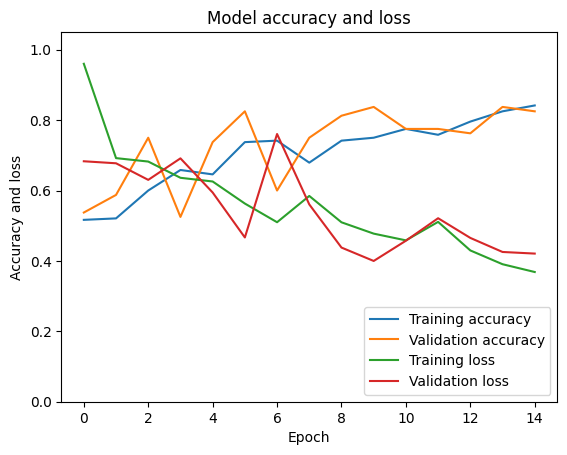

In [92]:
# Plot the training and the validation accuracy and loss in one figure
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model accuracy and loss')
plt.ylabel('Accuracy and loss')
plt.xlabel('Epoch')
plt.ylim(0, 1.05)
plt.legend(['Training accuracy', 'Validation accuracy', 'Training loss', 'Validation loss'], loc='lower right')
plt.show()

In [93]:
# Evaluate the model based on the test data
test_loss, test_acc = model.evaluate(test_set, verbose=2) # verbose=2 to suppress the progress bar
print(f'Test accuracy: {test_acc}')

3/3 - 1s - loss: 0.3600 - accuracy: 0.8375 - 1s/epoch - 355ms/step
Test accuracy: 0.8374999761581421


# Save the model

In [104]:
# Save the model as a TensorFlow SavedModel
# model.save('model_new_83')

INFO:tensorflow:Assets written to: model_new_83/assets


INFO:tensorflow:Assets written to: model_new_83/assets


# Load model

In [105]:
# Load the model
model = tf.keras.models.load_model('model_new_83')

# Classify a single image to test the pre-trained model

## Load random image and preprocess it to make it compatible with the model

In [121]:
# List all test images
test_images_dir = 'test_images'
test_images = os.listdir(test_images_dir)

# Select a random image path
random_image = random.choice(test_images)

# Full path to the randomly selected image
image_path = os.path.join(test_images_dir, random_image)

# Load and preprocess the image
img = load_img(image_path, target_size=(256, 256)) 
img_array = img_to_array(img)                                   # Convert the image to a numpy array
img_array_rescaled = img_array / 255.0                          # Scale the image
img_array_expanded = np.expand_dims(img_array_rescaled, axis=0) # expand_dims adds a dimension to the array to make it compatible with the model which expects a batch of images

# Predict the class of the image

1/1 [==============================] - 0s 81ms/step


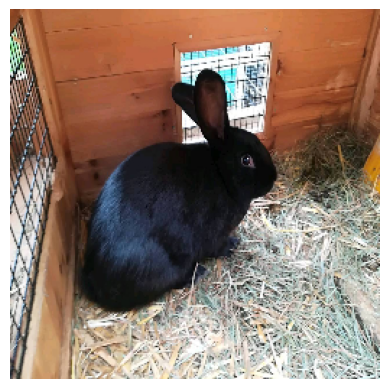

Predicted class: Kaninchen (0.9873509407043457)
Filename: Kaninchen2.jpg


In [122]:
# Predict with the model
predictions = model.predict(img_array_expanded)

# Assuming a binary classification (class1 or class2)
predicted_class = 'Feldhase' if predictions[0][0] < 0.5 else 'Kaninchen'

# Display the image and prediction
plt.imshow(img_array_rescaled)
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class} ({predictions[0][0]})')
print(f'Filename: {random_image}')